ML Assignment 2

1. kNN Approach

Load forestCover data and preprocess

In [24]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.neighbors import NearestNeighbors
import numpy as np

data = pd.read_csv('data/forestCover.csv')
#downsample data to 5%
data = data.sample(frac=0.05, random_state=42)
print("Shape of data after downsampling:", data.shape)

#drop "Facet" column because of correlation with "Aspect"
data = data.drop(columns=['Facet'])

#drop "Water_Level" column because it has cardinality of 1
#data = data.drop(columns=['Water_Level'])

#drop "Observation_ID" column
data = data.drop(columns=['Observation_ID'])

#drop "Inclination" column because of only noisy values
data = data.drop(columns=['Inclination'])

#convert categorical to binary
data['Soil_Type1'] = (data['Soil_Type1'] == 'positive').astype(int)




Shape of data after downsampling: (29051, 59)


Impute missing values using kNN

In [26]:

stratify_col = data['Cover_Type'].copy()
if stratify_col.isnull().any():
    stratify_col.fillna(stratify_col.mode()[0], inplace=True)

data.replace('?', np.nan, inplace=True)

for col in data.columns:
    if data[col].dtype == 'object':
         data[col] = pd.to_numeric(data[col], errors='ignore')

missing_values = data.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

numerical_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(exclude=np.number).columns.tolist()
print("Categorical features identified:", categorical_features)
numerical_features.remove('Cover_Type')

imputer_numerical = KNNImputer(n_neighbors=5)
data[numerical_features] = imputer_numerical.fit_transform(data[numerical_features])

#the only categorical feature has no missing values


Columns with missing values:
Slope    18
dtype: int64
Categorical features identified: []


/var/folders/yp/k8dsn2cx0y7bhmt7n9dq03tm0000gn/T/ipykernel_10300/1169659343.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col], errors='ignore')


Split Data, Scale, and Resample

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Original training dataset shape %s" % Counter(y_train))
counts = y_train.value_counts()
majority_class = counts.idxmax()
majority_count = counts.max()
target_samples = int(majority_count * 0.2)

sampling_strategy = {i: max(count, target_samples) for i, count in counts.items() if i != majority_class}

#SMOTE + Tomek Links takes to long
#smote_tomek = SMOTETomek(
#    smote=SMOTE(sampling_strategy=sampling_strategy, random_state=42),
#    random_state=42
#)

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
print("Resampled training dataset shape %s" % Counter(y_res))



Original training dataset shape Counter({2: 11420, 1: 8440, 3: 1402, 7: 781, 6: 710, 5: 363, 4: 124})
Resampled training dataset shape Counter({2: 11420, 1: 8440, 3: 2284, 6: 2284, 7: 2284, 4: 2284, 5: 2284})


kNN with Cross-Validation and Overfitting Visualization

In [29]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, cohen_kappa_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# To properly evaluate with cross-validation, we should use a pipeline
# to prevent data leakage from the scaler.
# NOTE: For a full CV evaluation, we would need to include the SMOTE step inside the pipeline
# for each fold. For simplicity and speed, we perform CV on the already resampled data.
# This gives an idea of model stability on the balanced data.
pipeline_knn = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors=1, metric='euclidean'))
])

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'kappa': make_scorer(cohen_kappa_score)
}
#classification report

# Perform cross-validation on the entire resampled dataset
# We use the resampled training data (X_res, y_res) for this
cv_results = cross_validate(pipeline_knn, X_res, y_res, cv=cv, scoring=scoring)

print("--- kNN 5-Fold Cross-Validation Results (for baseline k=1) ---")
print(f"F1 Score (macro): {cv_results['test_f1_macro'].mean():.4f} (+/- {cv_results['test_f1_macro'].std():.4f})")
print(f"Cohen's Kappa: {cv_results['test_kappa'].mean():.4f} (+/- {cv_results['test_kappa'].std():.4f})")


--- kNN 5-Fold Cross-Validation Results (for baseline k=1) ---
F1 Score (macro): 0.8780 (+/- 0.0028)
Cohen's Kappa: 0.7809 (+/- 0.0060)


Hyperparameter Tuning with GridSearchCV

In [30]:

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, cohen_kappa_score

# Definieren des Parameter-Rasters
param_grid = {
    'n_neighbors': [1, 2, 3, 6, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

halving_search = HalvingGridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=3,
    n_jobs=-1,
    return_train_score=True,
    factor=2,
    random_state=42
)
halving_search.fit(X_res, y_res)
print("Best Parameter:", halving_search.best_params_)
print("Beste F1-macro Score ):", halving_search.best_score_)

# Visualize CV results in a table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cv_results_df = pd.DataFrame(halving_search.cv_results_)
print("\\n--- HalvingGridSearchCV Cross-Validation Results ---")
cols_of_interest = [
    'param_n_neighbors', 'param_weights', 'param_metric',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]
existing_cols = [col for col in cols_of_interest if col in cv_results_df.columns]
print(cv_results_df[existing_cols].sort_values(by='rank_test_score'))
# Visualize CV results in a table

best_knn = halving_search.best_estimator_
# We must predict on the scaled test data
y_pred_best = best_knn.predict(X_test_scaled)
cols_of_interest = [
    'param_n_neighbors', 'param_weights', 'param_metric',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]
existing_cols = [col for col in cols_of_interest if col in cv_results_df.columns]
print(cv_results_df[existing_cols].sort_values(by='rank_test_score'))



# We must predict on the scaled test data
y_pred_best = best_knn.predict(X_test_scaled)

print('\\n--- Final Evaluation on the test data ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred_best, average='macro'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred_best):.4f}")
print('\\nClassification Report:')
print(classification_report(y_test, y_pred_best))




n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1955
max_resources_: 31280
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 20
n_resources: 1955
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.645) total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.672) total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.658) total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.641) total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.685) total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=1, weights=distance;, score=(train=1.000, test=0.645) total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=1

2. Decision Tree Approach

Preprocess data

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from sklearn.impute import KNNImputer

data_tree = pd.read_csv('data/forestCover.csv')
data_tree = data_tree.sample(frac=0.05, random_state=42)

#drop "Water_Level" column because it has cardinality of 1
#data_tree = data_tree.drop(columns=['Water_Level'])

#convert categorical to binary
data_tree['Soil_Type1'] = (data_tree['Soil_Type1'] == 'positive').astype(int)

#drop "Observation_ID" column
data_tree = data_tree.drop(columns=['Observation_ID'])

#drop "Inclination" column because of only noisy values
data_tree = data_tree.drop(columns=['Inclination'])

stratify_col = data_tree['Cover_Type'].copy()
if stratify_col.isnull().any():
    stratify_col.fillna(stratify_col.mode()[0], inplace=True)

data_tree.replace('?', np.nan, inplace=True)

for col in data_tree.columns:
    if data_tree[col].dtype == 'object':
         data_tree[col] = pd.to_numeric(data_tree[col], errors='ignore')

missing_values = data_tree.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

numerical_features = data_tree.select_dtypes(include=np.number).columns.tolist()
categorical_features = data_tree.select_dtypes(exclude=np.number).columns.tolist()
print("Categorical features identified:", categorical_features)
numerical_features.remove('Cover_Type')

imputer_numerical = KNNImputer(n_neighbors=5)
data_tree[numerical_features] = imputer_numerical.fit_transform(data_tree[numerical_features])

#we leave categorical features as is

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

print (data_tree.columns.tolist())
X = data_tree.drop('Cover_Type', axis=1)
y = data_tree['Cover_Type']
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#no scaling

print("Original training dataset shape %s" % Counter(y_train_tree))
counts = y_train_tree.value_counts()
majority_class = counts.idxmax()
majority_count = counts.max()
target_samples = int(majority_count * 0.2)

sampling_strategy = {i: max(count, target_samples) for i, count in counts.items() if i != majority_class}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res_tree, y_res_tree = smote.fit_resample(X_train_tree, y_train_tree)
print("Resampled training dataset shape %s" % Counter(y_res_tree))



/var/folders/yp/k8dsn2cx0y7bhmt7n9dq03tm0000gn/T/ipykernel_10300/1182787011.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data_tree[col] = pd.to_numeric(data_tree[col], errors='ignore')


Columns with missing values:
Slope    18
dtype: int64
Categorical features identified: []
['Elevation', 'Aspect', 'Facet', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'W

Hyperparameter Tuning for Decision Tree with HalvingGridSearchCV

In [35]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, cohen_kappa_score

# Define the parameter grid including pre- and post-pruning parameters
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'ccp_alpha': [0.0, 0.001, 0.01] # Post-pruning
}

# Instantiate the halving grid search
halving_search_tree = HalvingGridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_tree,
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1,
    factor=2,
    random_state=42
)

# Fit the grid search on the resampled data
halving_search_tree.fit(X_res_tree, y_res_tree)

# Print the best parameters and score
print("--- Decision Tree HalvingGridSearchCV Results ---")
print("Best Parameters:", halving_search_tree.best_params_)
print(f"Best F1-macro Score: {halving_search_tree.best_score_:.4f}")

# Get the best estimator
best_tree = halving_search_tree.best_estimator_

# Evaluate the best model on the test set
y_pred_best_tree = best_tree.predict(X_test_tree)

print('\n--- Final Evaluation on the Test Data ---')
print(f"Accuracy: {accuracy_score(y_test_tree, y_pred_best_tree):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test_tree, y_pred_best_tree, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test_tree, y_pred_best_tree):.4f}")
print('\nClassification Report:')
print(classification_report(y_test_tree, y_pred_best_tree))
print(f'\nDepth of the best tree: {best_tree.get_depth()}')

# Visualize CV results in a table
import pandas as pd
cv_results_tree_df = pd.DataFrame(halving_search_tree.cv_results_)
print("\n--- HalvingGridSearchCV Cross-Validation Results Table ---")
cols_of_interest_tree = [
    'param_criterion', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_ccp_alpha',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]
existing_cols_tree = [col for col in cols_of_interest_tree if col in cv_results_tree_df.columns]
print(cv_results_tree_df[existing_cols_tree].sort_values(by='rank_test_score'))


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 977
max_resources_: 31280
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 48
n_resources: 977
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=20

Comparison of both approaches

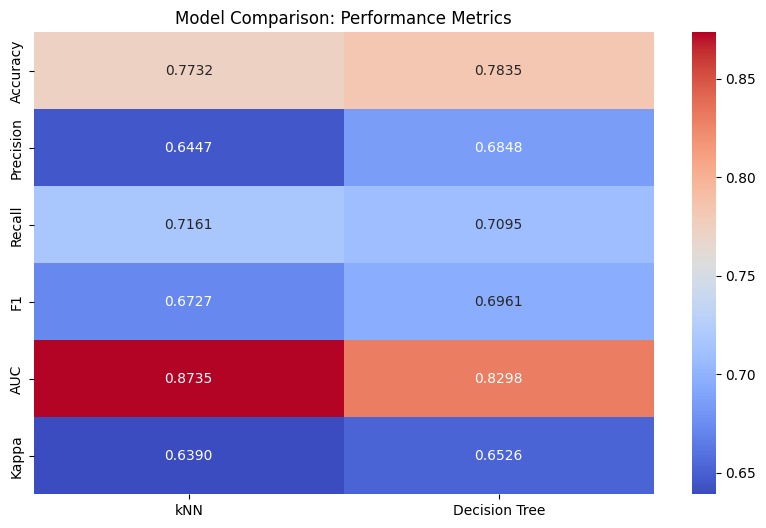

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Metrics for kNN Model ---
y_pred_knn = best_knn.predict(X_test_scaled)
y_proba_knn = best_knn.predict_proba(X_test_scaled)

knn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn, average='macro'),
    'Recall': recall_score(y_test, y_pred_knn, average='macro'),
    'F1': f1_score(y_test, y_pred_knn, average='macro'),
    'AUC': roc_auc_score(y_test, y_proba_knn, multi_class='ovr'),
    'Kappa': cohen_kappa_score(y_test, y_pred_knn)
}

# --- Metrics for Decision Tree Model ---
y_pred_tree = best_tree.predict(X_test_tree)
y_proba_tree = best_tree.predict_proba(X_test_tree)

tree_metrics = {
    'Accuracy': accuracy_score(y_test_tree, y_pred_tree),
    'Precision': precision_score(y_test_tree, y_pred_tree, average='macro'),
    'Recall': recall_score(y_test_tree, y_pred_tree, average='macro'),
    'F1': f1_score(y_test_tree, y_pred_tree, average='macro'),
    'AUC': roc_auc_score(y_test_tree, y_proba_tree, multi_class='ovr'),
    'Kappa': cohen_kappa_score(y_test_tree, y_pred_tree)
}

# --- Create DataFrame and Visualize ---
metrics_df = pd.DataFrame({'kNN': knn_metrics, 'Decision Tree': tree_metrics})

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="coolwarm")
plt.title('Model Comparison: Performance Metrics')
plt.show()
